# Atmospheric Effects on DORIS

## Troposphere

In [9]:
# Section 1 - Imports

import datetime
import attotime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
from os.path import join

from dsoclasses.doris.algorithms import beacon_nominal_frequency
from dsoclasses.rinex.doris.rinex import DorisRinex
from dsoclasses.time.pyattotime import at2pt, fsec2asec
from dsoclasses.orbits import sp3c, interpolator
from dsoclasses.geodesy import transformations
from dsoclasses.gnss import systems as gs
from dsoclasses.gnss import algorithms as alg
from dsoclasses.troposphere.vmf3 import SiteVmf3
from dsoclasses.sinex import sinex

# Section 2 – Define File Paths
data_path = "/home/xanthos/Software/AcademicSoftware/data"
drinex = join(data_path, "s6arx24001.001")
dpod = join(data_path, "dpod2020_041.snx")
dsp3 = join(data_path, "ssas6a20.b23357.e24001.DG_.sp3.001")

# Section 3 - Load Orbit Data + Initialize Interpolator 
intrp = interpolator.Sp3Interpolator.from_sp3(dsp3, ['L'], interval_in_sec=310, min_data_pts=10, itype='Barycentric')
# the sp3 only holds one satellite, let's get its id:
assert len(list(intrp._interpolators.keys())) == 1
satsp3_id = list(intrp._interpolators.keys())[0]

# Section 4 - Intitialize DorisRinex and select a beacon (Dionysos/DIOB)
rnx = DorisRinex(drinex)

# Section 5 - Choose a station and get coordinates (DIOB DORIS beacon)
site_name = 'DIOB'

# DIOB coordinates
diob_crd = sinex.extract_sinex_coordinates(dpod, [site_name], rnx.time_first_obs, True)[site_name]
rsta = np.array([diob_crd['X'], diob_crd['Y'], diob_crd['Z']])

lat, lon, hgt = transformations.car2ell(*rsta)
Rt = transformations.geodetic2lvlh(lat, lon)
R = Rt.transpose()

The total delay time which radio waves experience when traveling through the neutral atmosphere depending on the observation elevation angle ($e$) is commonly modeled with the parametrization:
$$
\Delta L(\varepsilon ) = \Delta L_\mathrm{h}^\mathrm{z} \cdot \hbox {mf}_\mathrm{h}(\varepsilon ) + \Delta L_\mathrm{w}^\mathrm{z} \cdot \hbox {mf}_\mathrm{w}(\varepsilon )
$$

where:
- $\Delta L(\varepsilon )$ total delay in [m],
- $\Delta L_\mathrm{h}^\mathrm{z}$ zenith path delay due to the hydrostatic part of neutral atmosphere,
- ${mf}_\mathrm{h}(\varepsilon )$ mapping function for the hydrostatic component,
- $\Delta L_\mathrm{w}^\mathrm{z}$ zenith path delay due to the wet part of neutral atmosphere, and
- ${mf}_\mathrm{w}(\varepsilon )$ mapping function for the wet component

Evidently, delay modeling is split into a hydrostatic (dry) part, which is mainly caused by the dry gases in the atmosphere, and a wet part which arises from water vapor and water particles in the atmosphere, each represented through a multiplication of the respective delay in zenith direction with a mapping function . The zenith hydrostatic delay can be determined with very high precision through pressure measurements at the site, as the weight of all air layers adds up to the surface pressure (Landskron & Böhm (2018).

### Hydrostatic Part

The most widely used formula to compute $\Delta L_\mathrm{h}^\mathrm{z}$ is due to Saastamoinen (1972) as revised by Davis et al. (1985), and reads:
$$
\Delta L_\mathrm{h}^\mathrm{z} = \frac{0.0022768 \cdot p}{1-0.00266 \cdot \cos (2\varphi )-0.28 \cdot 10^{-6} \cdot h_\mathrm{ell}}
$$
with $p$ being the pressure value (at the site) and and $\varphi$, $h_\mathrm{ell}$ the geographic latitude and ellipsoidal height of the station, respectively. We could use the DORIS-derived pressure values (from the RINEX files) to compute $\Delta L_\mathrm{h}^\mathrm{z}$:

In [10]:
# precompute the denominator
denom = 1. - 266e-5 * np.cos(2. * lat) - .28e-6 * hgt
def dlzh(pressure): return 22768e-7 * pressure

# lets store results to plot them later on
ts = []; dL = []; pr = [];

# for every block in the RINEX file
for block in rnx:
    # for every beacon in the block
    for beacon, data in block:
        # match DIOB
        if beacon == rnx.name2id(site_name):
            
            # use the block-provided clock correction to get to (approximate) TAI
            # date(TAI) = epoch + receiver clock offset
            tai = block.t() + attotime.attotimedelta(nanoseconds=block.clock_offset() * 1e9)

            # get pressure value 
            pressure = data['P']['value']

            # compute delay
            delay = dlzh(pressure)
            
            ts.append(tai)
            dL.append(delay)
            pr.append(pressure)

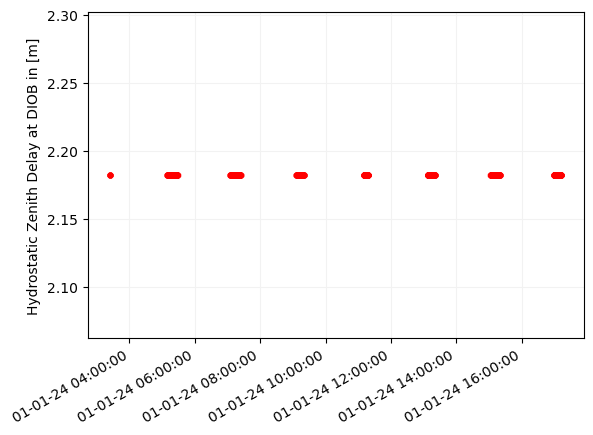

In [11]:
# Plot results w.r.t time ...
plt.scatter([at2pt(ti) for ti in ts], dL, alpha=0.5, s=12, c='red')
plt.grid(color='0.95')
plt.ylabel(f"Hydrostatic Zenith Delay at {site_name} in [m]")
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%y %H:%M:%S"))
plt.gcf().autofmt_xdate()
plt.show()

Measured pressure values remain constant (in this case 958.400 $Pa^2$) which forces the $\Delta L_\mathrm{h}^\mathrm{z}$ to hold a constant value trhoughout the time interval.

There are more precise ways to get $\Delta L_\mathrm{h}^\mathrm{z}$; here, we will be using the Site-wise VMF3 products, from the VMF [Data Server](https://vmf.geo.tuwien.ac.at/) (re3data.org: VMF Data Server; editing status 2020-12-14; re3data.org - Registry of Research Data Repositories. http://doi.org/10.17616/R3RD2H). Products include site-specific information, including both pressure and pre-computed $\Delta L_\mathrm{h}^\mathrm{z}$ for all active DORIS sites. We can extract the $\Delta L_\mathrm{h}^\mathrm{z}$ values from such data files, and compare to computed values using the DORIS RINEX pressure records.

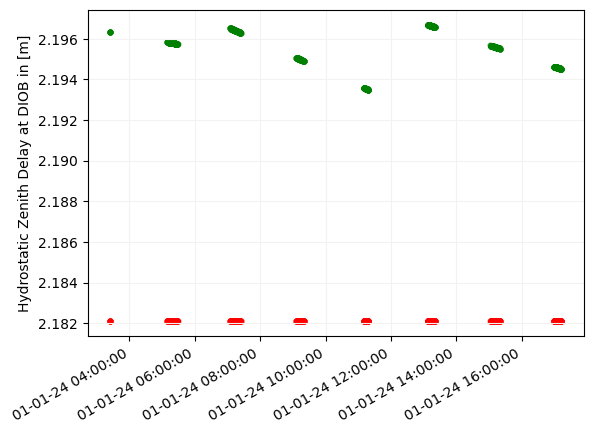

In [15]:
# VMF3 site-specific data for 2024
vmf3_data = join(data_path, "y2024.vmf3_d")
# Initialize VMF3 from (DORIS) site data
vmf = SiteVmf3(vmf3_data, site_name)
# Request VMF3 for each epoch in the ts array
vmf3_dL = [ vmf.tropo_dealy_info(site_name, lat, lon, np.pi, t) for t in [at2pt(ti) for ti in ts] ]
# Plot
plt.scatter([at2pt(ti) for ti in ts], dL, alpha=0.5, s=12, c='red')
plt.scatter([at2pt(ti) for ti in ts], [d["zhd"] for d in vmf3_dL], alpha=0.5, s=12, c='green')
plt.grid(color='0.95')
plt.ylabel(f"Hydrostatic Zenith Delay at {site_name} in [m]")
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%y %H:%M:%S"))
plt.gcf().autofmt_xdate()
plt.show()

In [8]:
# lets store time and range-rate measurements to plot them later on
ts = []; zd = []; elvs = [];

# for every block in the RINEX file
for block in rnx:
    # for every beacon in the block
    for beacon, data in block:
        # match DIOB
        if beacon == rnx.name2id('DIOB'):
            
            # use the block-provided clock correction to get to (approximate) TAI
            # date(TAI) = epoch + receiver clock offset
            tai = block.t() + attotime.attotimedelta(nanoseconds=block.clock_offset() * 1e9)
            
            # satellite position
            satx, saty, satz, _ = intrp.sat_at('L40', tai)
            rsat = np.array([satx, saty, satz])

            _, _, el = azele(rsat, diob_xyz)
            dT = vmf.tropo_dealy('DIOB', lat, lon, el, at2pt(tai))
            
            ts.append(tai)
            zd.append(dT)
            elvs.append(np.degrees(el))

plt.scatter([at2pt(ti) for ti in ts], zd, alpha=0.5, s=12, c='red')
plt.grid(color='0.95')
plt.ylabel(f"Tropospheric Dalay at DIOB [m]")
plt.title(f"Satellite {rnx.sat_name}")
# Format the datetime x-axis
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%j-%y %H:%M"))
# auto-rotate date labels for readability
plt.gcf().autofmt_xdate()
plt.show()

NameError: name 'diob_xyz' is not defined

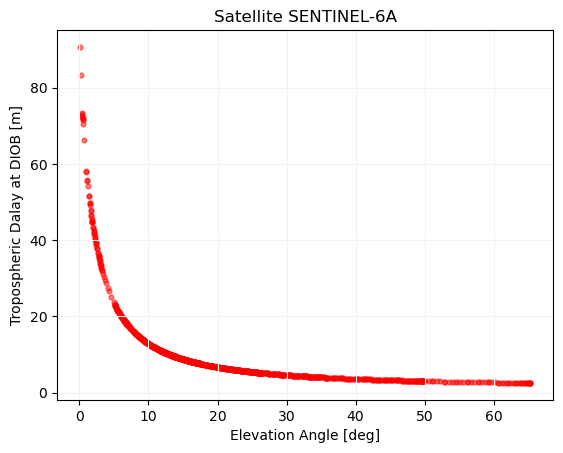

In [15]:
plt.scatter(elvs, zd, alpha=0.5, s=12, c='red')
plt.grid(color='0.95')
plt.ylabel(f"Tropospheric Dalay at DIOB [m]")
plt.xlabel(f"Elevation Angle [deg]")
plt.title(f"Satellite {rnx.sat_name}")
plt.show()